In [342]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# This is an incomplete analysis. However, a working Oscillator is displayed. 
# Accuracy score for model: 0.8559404172830689


# Strategy: Deep Learner Oscillator
# Implement an oscillator indicator derived from a deep learning model to
# determine if profitable pivot points (i.e., a higher low and 
# higher high for uptrends (HL,HH), and lower high and lower low (LH,LL) 
# for downtrends) can be detected by taking into account multiple timeframe contexts 
# (e.g., 1, 2, 5, 15, 60 minute charts).

# In simpler terms: Oscillations can be thought of as sigmoid functions i.e. this is a classification
# So we take this minute by minute dataset, and create features based on this HH-LL designation

# Really the goal is to implement a LSTM model which then produces "oscillator" i.e. a sigmoid function in its last 
# predictive layer. LSTMs (Long Short-Term Memory) are a type of recurrent neural network (RNN) 
# architecture that can capture both forward-looking and backward-looking dependencies in sequential data. 


# Ways to go: 
# 1) Experiment with various different DL models for better model performance and de-trending analysis. 
# 2) Generate Entry/Exit Signals based on Oscillations 
# 3) PnL and backtesting

# Then (after 1-3): More Questions can be asked
# Find best/worst case returns for intraday signals
# Produce a single output oscillator based on training with the SPY data only
# Forecast at the horizon what has been trained with both lookback / lookahead as is needed for both 1) knowing that a price action pivot point occurred and 2) that an entry signal had a path to a good or bad outcome. 
# Given that price action indicators are lagging, train a model with lookahead to produce a score for each intraday bar reflecting the probability that it is an actual price action pivot point

# We start with the data which is a intraday 1-min interval set 

df = pd.read_csv('QQQ_whole_ET.csv')
df

,DateTime,Open,High,Low,Close
0,2022-07-06 09:30:00,287.35,287.84,286.98,287.11
1,2022-07-06 09:31:00,287.01,287.76,286.83,287.41
2,2022-07-06 09:32:00,287.41,288.74,287.41,288.32
3,2022-07-06 09:33:00,288.33,288.65,288.09,288.33
4,2022-07-06 09:34:00,288.32,288.44,287.67,287.82
...,...,...,...,...,...
98010,2023-07-10 15:55:00,366.05,366.12,365.98,366.11
98011,2023-07-10 15:56:00,366.11,366.23,366.06,366.07
98012,2023-07-10 15:57:00,366.06,366.13,366.03,366.10
98013,2023-07-10 15:58:00,366.10,366.15,366.04,366.14


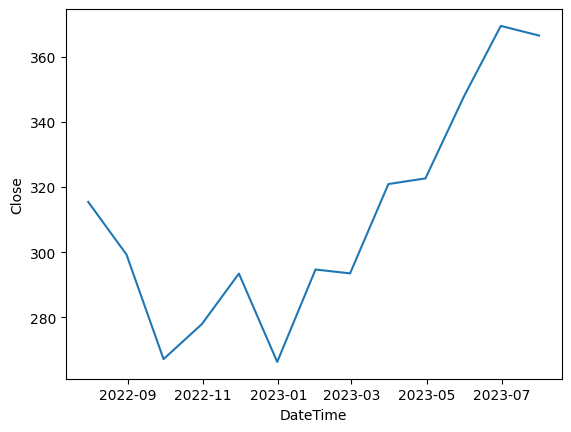

In [343]:
# Let's visualize this

import seaborn as sns


# Convert 'DateTime' column to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as the index of the DataFrame
df.set_index('DateTime', inplace=True)

# Resample the data on a monthly basis
monthly_data = df['Close'].resample('M').last()
monthly_data = monthly_data.reset_index()

# Extract the month and year from the DateTime column
monthly_data['Month'] = monthly_data['DateTime'].dt.month
monthly_data['Year'] = monthly_data['DateTime'].dt.year

# Visualize the monthly data
sns.lineplot(x='DateTime', y='Close', data=monthly_data)

# Display the plot
plt.show()


In [344]:
# Define the time intervals
time_intervals = [1,2,5, 15, 60]  # in minutes

# Calculate HH, HL, LH, LL features for each time interval
for interval in time_intervals:
    df[f'HL_{interval}'] = (df['Close'] > df['Close'].rolling(interval).min()).astype(int)
    df[f'HH_{interval}'] = (df['Close'] > df['Close'].rolling(interval).max()).astype(int)
    df[f'LH_{interval}'] = (df['Close'] < df['Close'].rolling(interval).max()).astype(int)
    df[f'LL_{interval}'] = (df['Close'] < df['Close'].rolling(interval).min()).astype(int)

# Create the dataset with HH, HL, LH, and LL features for each time interval
hhll_dataset = df[['Close'] + [f'HL_{interval}' for interval in time_intervals] +
                      [f'HH_{interval}' for interval in time_intervals] +
                      [f'LH_{interval}' for interval in time_intervals] +
                      [f'LL_{interval}' for interval in time_intervals]]

hhll_dataset

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,LH_1,LH_2,LH_5,LH_15,LH_60,LL_1,LL_2,LL_5,LL_15,LL_60
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-06 09:30:00,287.11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-07-06 09:31:00,287.41,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-07-06 09:32:00,288.32,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-07-06 09:33:00,288.33,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-07-06 09:34:00,287.82,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 15:55:00,366.11,0,1,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2023-07-10 15:56:00,366.07,0,0,1,1,1,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
2023-07-10 15:57:00,366.10,0,1,1,1,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [299]:
# I'm going to ignore creating an "Uptrend = HL + HH" and "Downtrend = LH+LL" column because 
# we have the raw data and a Deep Learner should be able to pick up the common pattern 

In [345]:
# Okay, so now need to figure out total return as we need a target variable. 
# Total return is just exit_price - entry price (multiplied by how much you put in)
# The easiest way I can think of doing this is utilizing our Simple Moving Avg strategy:

#Calculate the SMA
short_window = 10  # Short-term moving average window
long_window = 30  # Long-term moving average window

hhll_dataset['MA_short'] = hhll_dataset['Close'].rolling(short_window).mean()
hhll_dataset['MA_long'] = hhll_dataset['Close'].rolling(long_window).mean()

# Calculate entry/exit signals
hhll_dataset['Entry'] = np.where(hhll_dataset['MA_short'] > hhll_dataset['MA_long'].shift(), 1, 0)
hhll_dataset['Exit'] = np.where(hhll_dataset['MA_short'] < hhll_dataset['MA_long'].shift(), 1, 0)

# Calculate entry and exit prices
hhll_dataset['Entry_Price'] = np.where(hhll_dataset['Entry'] == 1, hhll_dataset['Close'], np.nan)
hhll_dataset['Exit_Price'] = np.where(hhll_dataset['Exit'] == 1, hhll_dataset['Close'], np.nan)

# Forward fill entry and exit prices to hold until the next trade
hhll_dataset['Entry_Price'].ffill(inplace=True)
hhll_dataset['Exit_Price'].ffill(inplace=True)


In [346]:
# Total Return

hhll_dataset['Total_Return'] = hhll_dataset['Exit_Price'] - hhll_dataset['Entry_Price']
hhll_dataset


,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,LL_5,LL_15,LL_60,MA_short,MA_long,Entry,Exit,Entry_Price,Exit_Price,Total_Return
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-06 09:30:00,287.11,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:31:00,287.41,0,1,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:32:00,288.32,0,1,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:33:00,288.33,0,1,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:34:00,287.82,0,0,1,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 15:55:00,366.11,0,1,1,1,1,0,0,0,0,...,0,0,0,365.858,365.880333,0,1,365.86,366.11,0.25
2023-07-10 15:56:00,366.07,0,0,1,1,1,0,0,0,0,...,0,0,0,365.894,365.888333,1,0,366.07,366.11,0.04
2023-07-10 15:57:00,366.10,0,1,1,1,1,0,0,0,0,...,0,0,0,365.934,365.895333,1,0,366.10,366.11,0.01


In [253]:
# nan_count = hhll_dataset.isna().sum()
# nan_count
# df.dropna(inplace=True)
# hhll_dataset
# Very few NaN so drop them

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,LL_5,LL_15,LL_60,MA_short,MA_long,Entry,Exit,Entry_Price,Exit_Price,Total_Return
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-06 09:30:00,287.11,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:31:00,287.41,0,1,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:32:00,288.32,0,1,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:33:00,288.33,0,1,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
2022-07-06 09:34:00,287.82,0,0,1,0,0,0,0,0,0,...,0,0,0,NaN,NaN,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 15:55:00,366.11,0,1,1,1,1,0,0,0,0,...,0,0,0,365.858,365.880333,0,1,365.86,366.11,0.25
2023-07-10 15:56:00,366.07,0,0,1,1,1,0,0,0,0,...,0,0,0,365.894,365.888333,1,0,366.07,366.11,0.04
2023-07-10 15:57:00,366.10,0,1,1,1,1,0,0,0,0,...,0,0,0,365.934,365.895333,1,0,366.10,366.11,0.01


In [347]:
# Create Binary Target for classification problem

hhll_dataset['Target'] = hhll_dataset['Total_Return'].apply(lambda x: 1 if x > 0 else 0)
hhll_dataset

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,LL_15,LL_60,MA_short,MA_long,Entry,Exit,Entry_Price,Exit_Price,Total_Return,Target
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-07-06 09:30:00,287.11,0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0
2022-07-06 09:31:00,287.41,0,1,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0
2022-07-06 09:32:00,288.32,0,1,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0
2022-07-06 09:33:00,288.33,0,1,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0
2022-07-06 09:34:00,287.82,0,0,1,0,0,0,0,0,0,...,0,0,NaN,NaN,0,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 15:55:00,366.11,0,1,1,1,1,0,0,0,0,...,0,0,365.858,365.880333,0,1,365.86,366.11,0.25,1
2023-07-10 15:56:00,366.07,0,0,1,1,1,0,0,0,0,...,0,0,365.894,365.888333,1,0,366.07,366.11,0.04,1
2023-07-10 15:57:00,366.10,0,1,1,1,1,0,0,0,0,...,0,0,365.934,365.895333,1,0,366.10,366.11,0.01,1


In [226]:
# If you need all the column names for feature selection

# column_names = ['DateTime', 'Close'] + [f'HL_{interval}' for interval in time_intervals] + \
#                [f'HH_{interval}' for interval in time_intervals] + \
#                [f'LH_{interval}' for interval in time_intervals] + \
#                [f'LL_{interval}' for interval in time_intervals]

# # Create a string with column names separated by commas and enclosed within single quotes
# column_names_string = ', '.join([f"'{name}'" for name in column_names])

# # Print the column names string
# print(column_names_string)

In [348]:
#NaN Check (Drop NA cus its very small number)
nan_count = hhll_dataset.isna().sum()
nan_count


Close            0
HL_1             0
HL_2             0
HL_5             0
HL_15            0
HL_60            0
HH_1             0
HH_2             0
HH_5             0
HH_15            0
HH_60            0
LH_1             0
LH_2             0
LH_5             0
LH_15            0
LH_60            0
LL_1             0
LL_2             0
LL_5             0
LL_15            0
LL_60            0
MA_short         9
MA_long         29
Entry            0
Exit             0
Entry_Price     30
Exit_Price      49
Total_Return    49
Target           0
dtype: int64

In [349]:
# Since this is a time series problem, when an event occured is vital. So we will convert 
# DateTime into additional features

hhll_dataset.reset_index(level=0, inplace=True)


hhll_dataset['Year'] = hhll_dataset['DateTime'].dt.year
hhll_dataset['Month'] = hhll_dataset['DateTime'].dt.month
hhll_dataset['Day'] = hhll_dataset['DateTime'].dt.day
hhll_dataset['Hour'] = hhll_dataset['DateTime'].dt.hour
hhll_dataset['Minute'] = hhll_dataset['DateTime'].dt.minute
hhll_dataset['DayOfWeek'] = hhll_dataset['DateTime'].dt.dayofweek
hhll_dataset['DayOfYear'] = hhll_dataset['DateTime'].dt.dayofyear
hhll_dataset['WeekOfYear'] = hhll_dataset['DateTime'].dt.weekofyear


hhll_dataset


,DateTime,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,...,Total_Return,Target,Year,Month,Day,Hour,Minute,DayOfWeek,DayOfYear,WeekOfYear
0,2022-07-06 09:30:00,287.11,0,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,30,2,187,27
1,2022-07-06 09:31:00,287.41,0,1,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,31,2,187,27
2,2022-07-06 09:32:00,288.32,0,1,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,32,2,187,27
3,2022-07-06 09:33:00,288.33,0,1,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,33,2,187,27
4,2022-07-06 09:34:00,287.82,0,0,1,0,0,0,0,0,...,NaN,0,2022,7,6,9,34,2,187,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98010,2023-07-10 15:55:00,366.11,0,1,1,1,1,0,0,0,...,0.25,1,2023,7,10,15,55,0,191,28
98011,2023-07-10 15:56:00,366.07,0,0,1,1,1,0,0,0,...,0.04,1,2023,7,10,15,56,0,191,28
98012,2023-07-10 15:57:00,366.10,0,1,1,1,1,0,0,0,...,0.01,1,2023,7,10,15,57,0,191,28
98013,2023-07-10 15:58:00,366.14,0,1,1,1,1,0,0,0,...,-0.03,0,2023,7,10,15,58,0,191,28


In [350]:
# Lets check out this target column
column_description = hhll_dataset['Target'].describe()
print(column_description)

count    98015.000000
mean         0.191430
std          0.393429
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Target, dtype: float64


In [351]:
# Delete DateTime
hhll_dataset.drop('DateTime', axis=1, inplace=True)
hhll_dataset

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,Total_Return,Target,Year,Month,Day,Hour,Minute,DayOfWeek,DayOfYear,WeekOfYear
0,287.11,0,0,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,30,2,187,27
1,287.41,0,1,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,31,2,187,27
2,288.32,0,1,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,32,2,187,27
3,288.33,0,1,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,33,2,187,27
4,287.82,0,0,1,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,34,2,187,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98010,366.11,0,1,1,1,1,0,0,0,0,...,0.25,1,2023,7,10,15,55,0,191,28
98011,366.07,0,0,1,1,1,0,0,0,0,...,0.04,1,2023,7,10,15,56,0,191,28
98012,366.10,0,1,1,1,1,0,0,0,0,...,0.01,1,2023,7,10,15,57,0,191,28
98013,366.14,0,1,1,1,1,0,0,0,0,...,-0.03,0,2023,7,10,15,58,0,191,28


In [310]:
nan_count = hhll_dataset.isna().sum()
hhll_dataset.dropna(axis=0,inplace=True)
nan_count

Close            0
HL_1             0
HL_2             0
HL_5             0
HL_15            0
HL_60            0
HH_1             0
HH_2             0
HH_5             0
HH_15            0
HH_60            0
LH_1             0
LH_2             0
LH_5             0
LH_15            0
LH_60            0
LL_1             0
LL_2             0
LL_5             0
LL_15            0
LL_60            0
MA_short         9
MA_long         29
Entry            0
Exit             0
Entry_Price     30
Exit_Price      49
Total_Return    49
Target           0
Year             0
Month            0
Day              0
Hour             0
Minute           0
DayOfWeek        0
DayOfYear        0
WeekOfYear       0
dtype: int64

In [352]:
hhll_dataset
# Perfect data set 

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,Total_Return,Target,Year,Month,Day,Hour,Minute,DayOfWeek,DayOfYear,WeekOfYear
0,287.11,0,0,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,30,2,187,27
1,287.41,0,1,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,31,2,187,27
2,288.32,0,1,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,32,2,187,27
3,288.33,0,1,0,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,33,2,187,27
4,287.82,0,0,1,0,0,0,0,0,0,...,NaN,0,2022,7,6,9,34,2,187,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98010,366.11,0,1,1,1,1,0,0,0,0,...,0.25,1,2023,7,10,15,55,0,191,28
98011,366.07,0,0,1,1,1,0,0,0,0,...,0.04,1,2023,7,10,15,56,0,191,28
98012,366.10,0,1,1,1,1,0,0,0,0,...,0.01,1,2023,7,10,15,57,0,191,28
98013,366.14,0,1,1,1,1,0,0,0,0,...,-0.03,0,2023,7,10,15,58,0,191,28


In [353]:
counts = hhll_dataset['Target'].value_counts()
print(counts)
#This shows that there is a class imbalance in the data. So we will have to use class weights

0    79252
1    18763
Name: Target, dtype: int64


In [354]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.utils.class_weight import compute_sample_weight
from keras.optimizers import Adam


# Define the feature and target variables
features = hhll_dataset.drop('Target', axis=1)
target = hhll_dataset['Target']

# Scaling the features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = scaler.fit_transform(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# Reshape the input data to match the LSTM input shape (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [314]:
hhll_dataset

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,Total_Return,Target,Year,Month,Day,Hour,Minute,DayOfWeek,DayOfYear,WeekOfYear
49,286.66,0,0,1,1,0,0,0,0,0,...,-0.30,0,2022,7,6,10,19,2,187,27
50,286.89,0,1,1,1,0,0,0,0,0,...,-0.07,0,2022,7,6,10,20,2,187,27
51,286.31,0,0,0,0,0,0,0,0,0,...,-0.65,0,2022,7,6,10,21,2,187,27
52,286.58,0,1,1,1,0,0,0,0,0,...,-0.38,0,2022,7,6,10,22,2,187,27
53,287.11,0,1,1,1,0,0,0,0,0,...,0.15,1,2022,7,6,10,23,2,187,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98010,366.11,0,1,1,1,1,0,0,0,0,...,0.25,1,2023,7,10,15,55,0,191,28
98011,366.07,0,0,1,1,1,0,0,0,0,...,0.04,1,2023,7,10,15,56,0,191,28
98012,366.10,0,1,1,1,1,0,0,0,0,...,0.01,1,2023,7,10,15,57,0,191,28
98013,366.14,0,1,1,1,1,0,0,0,0,...,-0.03,0,2023,7,10,15,58,0,191,28


In [355]:
target

0        0
1        0
2        0
3        0
4        0
        ..
98010    1
98011    1
98012    1
98013    0
98014    0
Name: Target, Length: 98015, dtype: int64

In [356]:
features
# features.dropna(axis=0, inplace=True)
# features

,Close,HL_1,HL_2,HL_5,HL_15,HL_60,HH_1,HH_2,HH_5,HH_15,...,Exit_Price,Total_Return,Year,Month,Day,Hour,Minute,DayOfWeek,DayOfYear,WeekOfYear
0,287.11,0,0,0,0,0,0,0,0,0,...,NaN,NaN,2022,7,6,9,30,2,187,27
1,287.41,0,1,0,0,0,0,0,0,0,...,NaN,NaN,2022,7,6,9,31,2,187,27
2,288.32,0,1,0,0,0,0,0,0,0,...,NaN,NaN,2022,7,6,9,32,2,187,27
3,288.33,0,1,0,0,0,0,0,0,0,...,NaN,NaN,2022,7,6,9,33,2,187,27
4,287.82,0,0,1,0,0,0,0,0,0,...,NaN,NaN,2022,7,6,9,34,2,187,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98010,366.11,0,1,1,1,1,0,0,0,0,...,366.11,0.25,2023,7,10,15,55,0,191,28
98011,366.07,0,0,1,1,1,0,0,0,0,...,366.11,0.04,2023,7,10,15,56,0,191,28
98012,366.10,0,1,1,1,1,0,0,0,0,...,366.11,0.01,2023,7,10,15,57,0,191,28
98013,366.14,0,1,1,1,1,0,0,0,0,...,366.11,-0.03,2023,7,10,15,58,0,191,28


In [334]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Class weights cus skewed target
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights = dict(enumerate(class_weights))

# Train the model
model.fit(X_train, y_train, class_weight=class_weights, epochs=10, batch_size=32)



2023-07-12 02:27:57.883455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 02:27:57.886331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 02:27:57.888092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-07-12 02:27:58.730584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 02:27:58.733903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 02:27:58.736100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2450/2450 [==============================] - 85s 33ms/step - loss: 0.3046
Epoch 2/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.3037
Epoch 3/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.2996
Epoch 4/10
2450/2450 [==============================] - 77s 31ms/step - loss: 0.2993
Epoch 5/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.2904
Epoch 6/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.2752
Epoch 7/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.2584
Epoch 8/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.2510
Epoch 9/10
2450/2450 [==============================] - 78s 32ms/step - loss: 0.2422
Epoch 10/10
2450/2450 [==============================] - 288s 118ms/step - loss: 0.2162


In [365]:
# Make predictions
predictions = model.predict(X_test)
predictions #should be an array



613/613 [==============================] - 7s 11ms/step


array([[4.47295338e-01],
       [1.16783485e-05],
       [1.37776181e-01],
       ...,
       [1.31572232e-01],
       [3.08871865e-02],
       [2.21079320e-01]], dtype=float32)

In [366]:
predictions.shape

(19603, 1)

In [367]:
X_test.shape

(19603, 36, 1)

In [368]:
y_test.shape

(19603,)

In [369]:
# Generate the oscillator values
oscillator = np.squeeze(predictions)

close_price = hhll_dataset['Close']


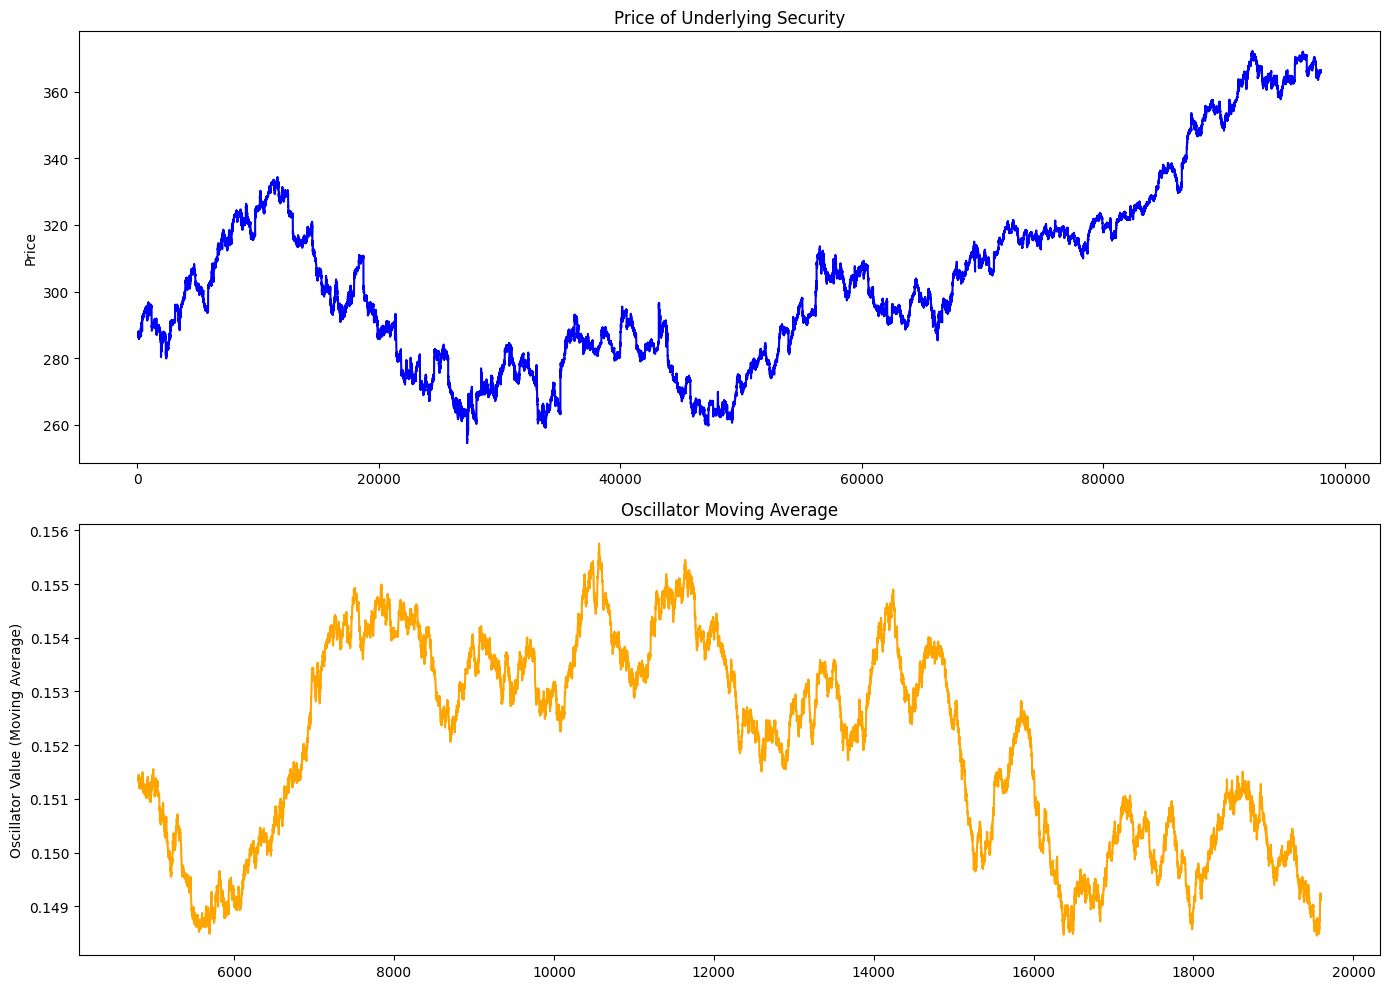

In [337]:
#Not descriptive ^^ at all so find trends again...

# Have to find trends in the oscillator i.e. our predictions from the LSTM 
# Use MA again
# Convert the oscillator array to a pandas Series
oscillator_series = pd.Series(oscillator)

# Set the index of the oscillator series (if not already set)
# oscillator_series.index = ...

# Calculate the moving average with a specified window size
window_size = 4800 #2 week trends i.e. 8 hours, every minute, for 10 days = 4800
moving_average = oscillator_series.rolling(window_size).mean()

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plotting the price of the underlying security
sns.lineplot(ax=axes[0], x=close_price.index, y=close_price, color='blue')
axes[0].set_title('Price of Underlying Security')
axes[0].set_ylabel('Price')

# Plotting the moving average of the oscillator
sns.lineplot(ax=axes[1], x=oscillator_series.index, y=moving_average, color='orange')
axes[1].set_title('Oscillator Moving Average')
axes[1].set_ylabel('Oscillator Value (Moving Average)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()




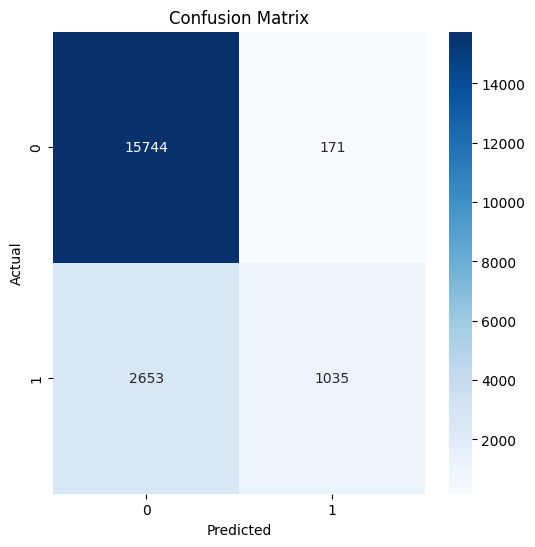

In [370]:
from sklearn.metrics import confusion_matrix

# Generate class predictions
y_pred_class = (oscillator > 0.5).astype(int)  # Convert probabilities into class predictions 

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix with seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [379]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_class)
accuracy

#Not horrible but could be better

0.8559404172830689